# Exploring the Essemble of Random Forests

In [4]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from scipy.stats import gaussian_kde
import statsmodels.api as sm
import seaborn as sns
sns.set()
sns.set_style("whitegrid") 
sns.set_context("paper")
import sigfig

In [5]:
results_dir = 'E:/Krish_New/Dynamic_Vegetation_Project_Storage/Random_Forest_Results_On_Super_Group_Results'
results_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results_new'
directory = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/MODELLED_TRAINING_DATA'
plots_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/Thesis/Plots_For_Thesis/Chapter 3'

In [6]:
test_evaluation_set = pd.read_csv('../RESULTS/Random_Forest_Results_On_Super_Group_Results_new/Evaluation_Plot.csv')

In [1]:
SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460']

MEAN_ANNUAL_CLIMATE_FEATURES = ['MAT', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

TOPOGRAPHIC_FEATURES = ['aspect_1s', 'twi_1s']

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + TEMP_FEATURES + SOIL_FEATURES + TOPOGRAPHIC_FEATURES + MEAN_ANNUAL_CLIMATE_FEATURES

TEMPORAL_FEATURES = SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + TEMP_FEATURES
SPATIAL_FEATURES = SOIL_FEATURES + TOPOGRAPHIC_FEATURES + MEAN_ANNUAL_CLIMATE_FEATURES

In [3]:
len(TEMPORAL_FEATURES + SPATIAL_FEATURES)

32

In [7]:
ordered_veg_list = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree.Palm',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp/Med Tree.Palm',          'Temp/Med Shrub',  'Temp/Med Tussock.grass',
                    'Tropical/Savanna Tree.Palm',  'Tropical/Savanna Tussock.grass']

In [15]:
# So, the schema will be like this: 'veg name' = [slope, intercept, r, p, se]
results_metrics_dict = {}

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


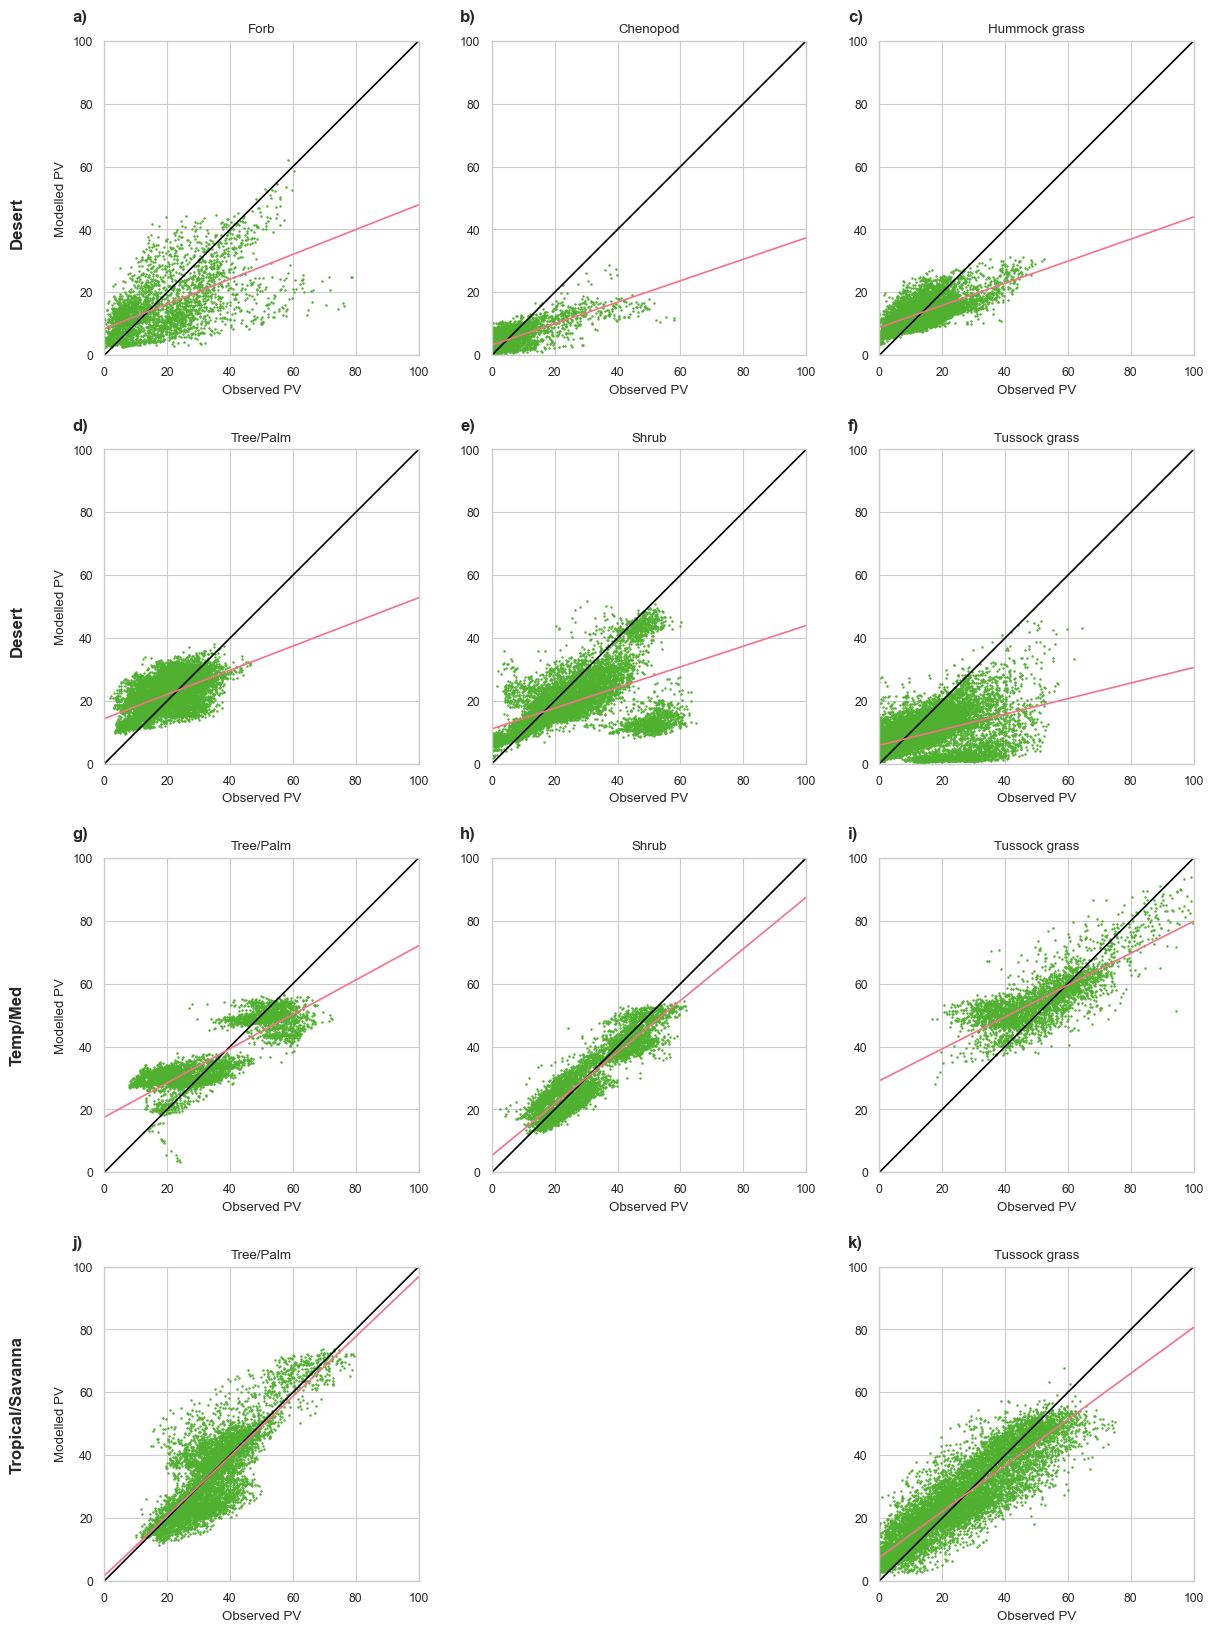

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']
one_to_one = [i for i in range(101)]

for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    test_evaluation_set_group.plot(kind = 'scatter', x = 'pv_filter', y = 'pv_median', ax = ax, s = 0.9, **{'color' : list(sns.color_palette("husl", 3))[1], 'alpha' : 1} )
    ax.plot(one_to_one,one_to_one, color = 'black')
    
    #Add density contours 
    #sns.kdeplot(x= test_evaluation_set_group['pv_filter'],
    #            y= test_evaluation_set_group['pv_median'], ax = ax)
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['pv_filter'], y = test_evaluation_set_group['pv_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue
    
    ax.plot(np.array(one_to_one), np.array(one_to_one)*slope + intercept, **{'color' : list(sns.color_palette("husl", 3))[0]})
    
    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    
    adjust_r2 = 1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    rmse = root_mean_squared_error(test_evaluation_set_group['pv_filter'], test_evaluation_set_group['pv_median'])
    bias = np.mean(test_evaluation_set_group['pv_filter']) - np.mean(test_evaluation_set_group['pv_median'])
    
    results_metrics_dict[chosen_group] = [slope, intercept, r**2, adjust_r2, p_value, rmse, bias] # square the r to get coefficient of determinaton
    
   
    # x and y limits 
    ax.set_xlim((0,100))
    ax.set_ylim((0,100))
    ax.set_aspect('equal')
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree/Palm'
    ax.title.set_text(f'{veg_name}')
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel('Modelled PV') 
        ax.text(-0.3, 0.35, chosen_group.split(" ")[0], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', rotation=90)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Observed PV')
plt.subplots_adjust(wspace=-0.5, hspace=0.3)


In [8]:
pv_stats = pd.DataFrame.from_dict(results_metrics_dict).T.rename(columns = {
0 : 'slope',
1 : 'intercept',
2 : 'R2',
3 : 'adj_r2',
4 : 'p-value',
5 : 'rmse', 
6 : 'bias'})

#slope, intercept, r, p, se 

In [9]:
pv_stats

,slope,intercept,R2,adj_r2,p-value,rmse,bias
Desert Forb,0.394543,8.393207,0.331933,0.331721,9.068553e-279,11.843804,3.040208
Desert Chenopod,0.341329,3.203316,0.537431,0.537368,0.000000e+00,5.008961,-0.551032
Desert Hummock.grass,0.351401,8.838258,0.444397,0.444312,0.000000e+00,6.369720,0.078438
Desert Tree.Palm,0.384533,14.376256,0.305815,0.305740,0.000000e+00,6.740119,-2.257103
Desert Shrub,0.328596,11.112642,0.294217,0.294141,0.000000e+00,13.775697,5.257334
Desert Tussock.grass,0.247668,5.869735,0.224261,0.224210,0.000000e+00,10.439070,3.723842
Temp/Med Tree.Palm,0.545516,17.548281,0.727340,0.727281,0.000000e+00,8.762727,-1.950838
Temp/Med Shrub,0.821666,5.343832,0.829315,0.829280,0.000000e+00,5.019091,0.166694
Temp/Med Tussock.grass,0.507308,29.133426,0.629373,0.629257,0.000000e+00,9.751287,-3.795414
Tropical/Savanna Tree.Palm,0.951651,1.593469,0.659584,0.659527,0.000000e+00,7.846017,0.071326


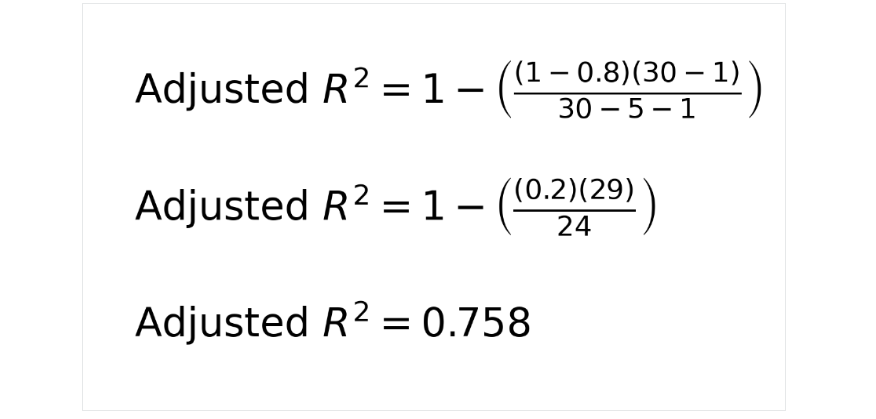

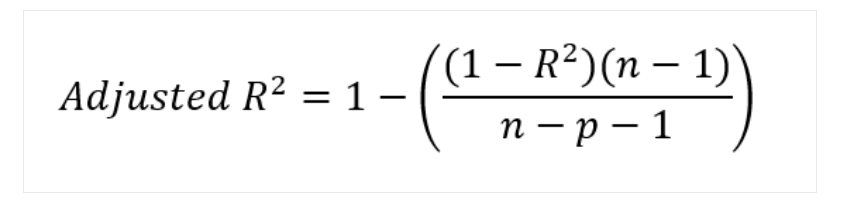

In [10]:

results_metrics_dict = {}


for chosen_group in ordered_veg_list:
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['pv_filter'], y = test_evaluation_set_group['pv_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue

    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    adjust_r2 = 1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    rmse = root_mean_squared_error(test_evaluation_set_group['pv_filter'], test_evaluation_set_group['pv_median'])
    bias = np.mean(test_evaluation_set_group['pv_filter']) - np.mean(test_evaluation_set_group['pv_median'])
    results_metrics_dict[chosen_group] = [adjust_r2, rmse] # square the r to get coefficient of determinaton
   

pv_stats = pd.DataFrame.from_dict(results_metrics_dict).T.rename(columns = {
0 : 'Adjusted R2',
1 : 'RMSE'})

#pv_stats['Vegetation Class'] = pv_stats.index

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


In [11]:

results_metrics_dict = {}


for chosen_group in ordered_veg_list:
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['npv_filter'], y = test_evaluation_set_group['npv_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue

    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    adjust_r2 = 1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    rmse = root_mean_squared_error(test_evaluation_set_group['npv_filter'], test_evaluation_set_group['npv_median'])
    bias = np.mean(test_evaluation_set_group['npv_filter']) - np.mean(test_evaluation_set_group['npv_median'])
    results_metrics_dict[chosen_group] = [adjust_r2, rmse] # square the r to get coefficient of determinaton
   

npv_stats = pd.DataFrame.from_dict(results_metrics_dict).T.rename(columns = {
0 : 'Adjusted R2',
1 : 'RMSE'})

#npv_stats['Vegetation Class'] = npv_stats.index

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


In [12]:

results_metrics_dict = {}


for chosen_group in ordered_veg_list:
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['bs_filter'], y = test_evaluation_set_group['bs_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue

    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    adjust_r2 = 1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    rmse = root_mean_squared_error(test_evaluation_set_group['bs_filter'], test_evaluation_set_group['bs_median'])
    bias = np.mean(test_evaluation_set_group['bs_filter']) - np.mean(test_evaluation_set_group['bs_median'])
    results_metrics_dict[chosen_group] = [adjust_r2, rmse] # square the r to get coefficient of determinaton
   

bs_stats = pd.DataFrame.from_dict(results_metrics_dict).T.rename(columns = {
0 : 'Adjusted R2',
1 : 'RMSE'})

#bs_stats['Vegetation Class'] = bs_stats.index

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


In [13]:
columns_plotable = ['Slope', 'Intercept', 'R2', 'Adjusted R2', 'p-value', 'RMSE', 'Bias']

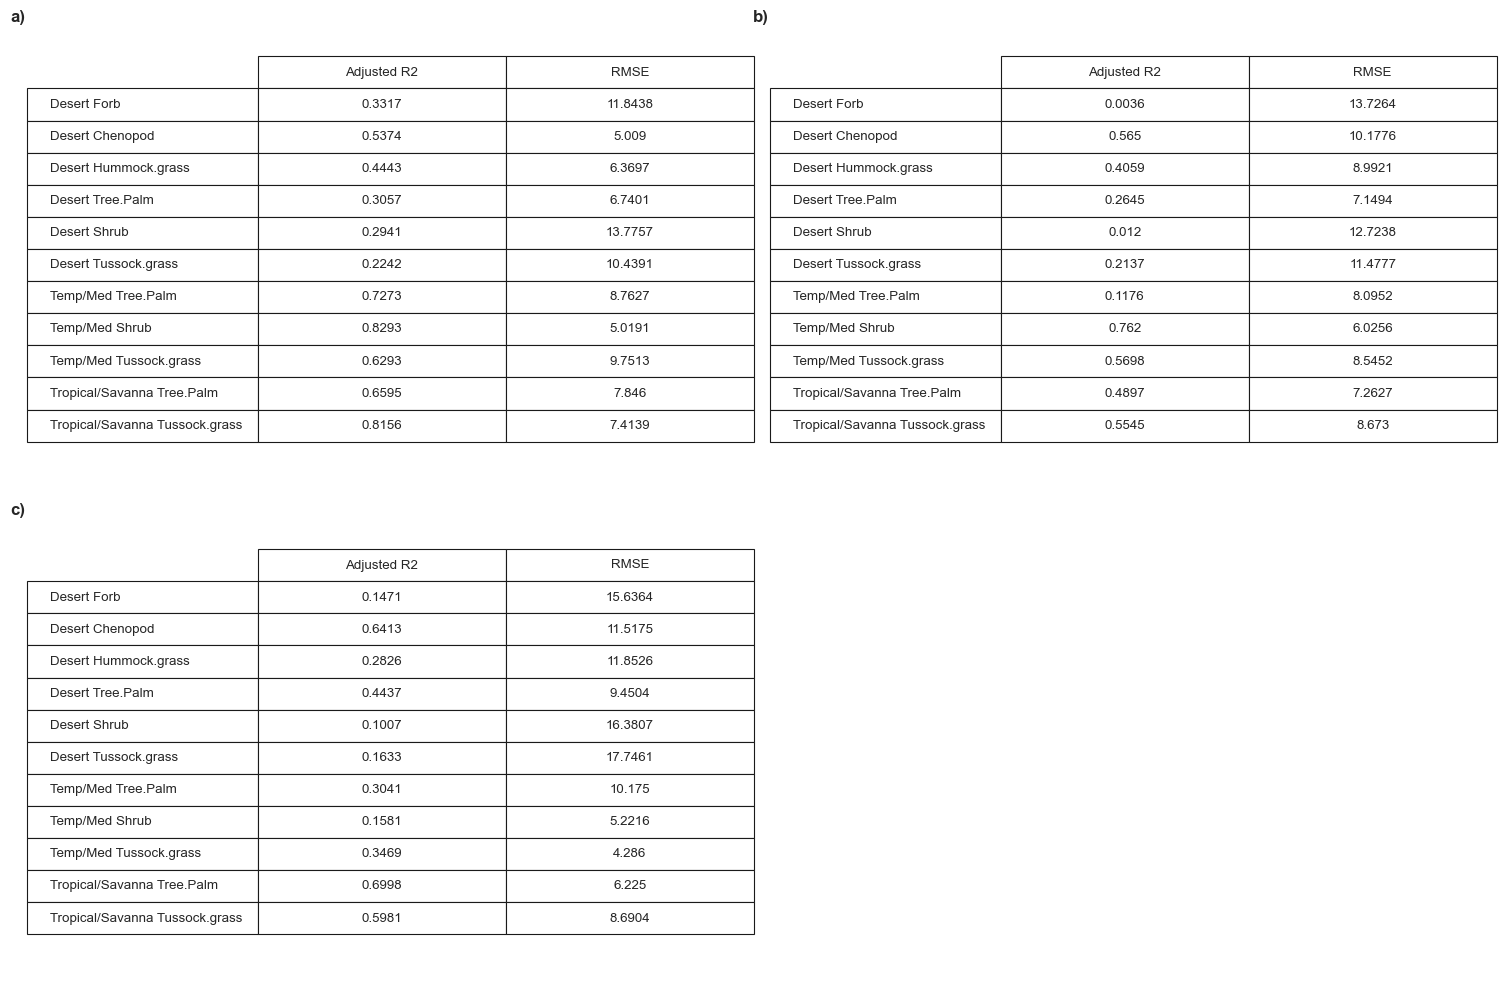

In [14]:
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace= 1.1)

for i, ax in enumerate(axes.flat):
    
    ax.axis('off')  
    
    if i > 2:
        continue 
    
    if i == 0:
        table = pd.plotting.table(ax=ax, data=np.round(pv_stats, 4), loc='center', cellLoc='center')
        #ax.title.set_text('PV')
    elif i == 1:
        table = pd.plotting.table(ax=ax, data=np.round(npv_stats, 4), loc='center', cellLoc='center')
        #ax.title.set_text('NPV')
    elif i == 2:
        table = pd.plotting.table(ax=ax, data=np.round(bs_stats, 4), loc='center', cellLoc='center')
        #ax.title.set_text('BS')
    
    
    ax.text(-0.5, 1, labels[i], transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top')
    #table.auto_set_font_size(False)
    #table.set_fontsize(10)
    #table.scale(1.5, 1)  # Scale table size if needed to improve fit
    
    
    
plt.tight_layout()
plt.show()

In [15]:
fig.savefig(f'{plots_dir}/Evaluation_Metrics_Plots.png')

# Now with the numbers on the plot 

# PV

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


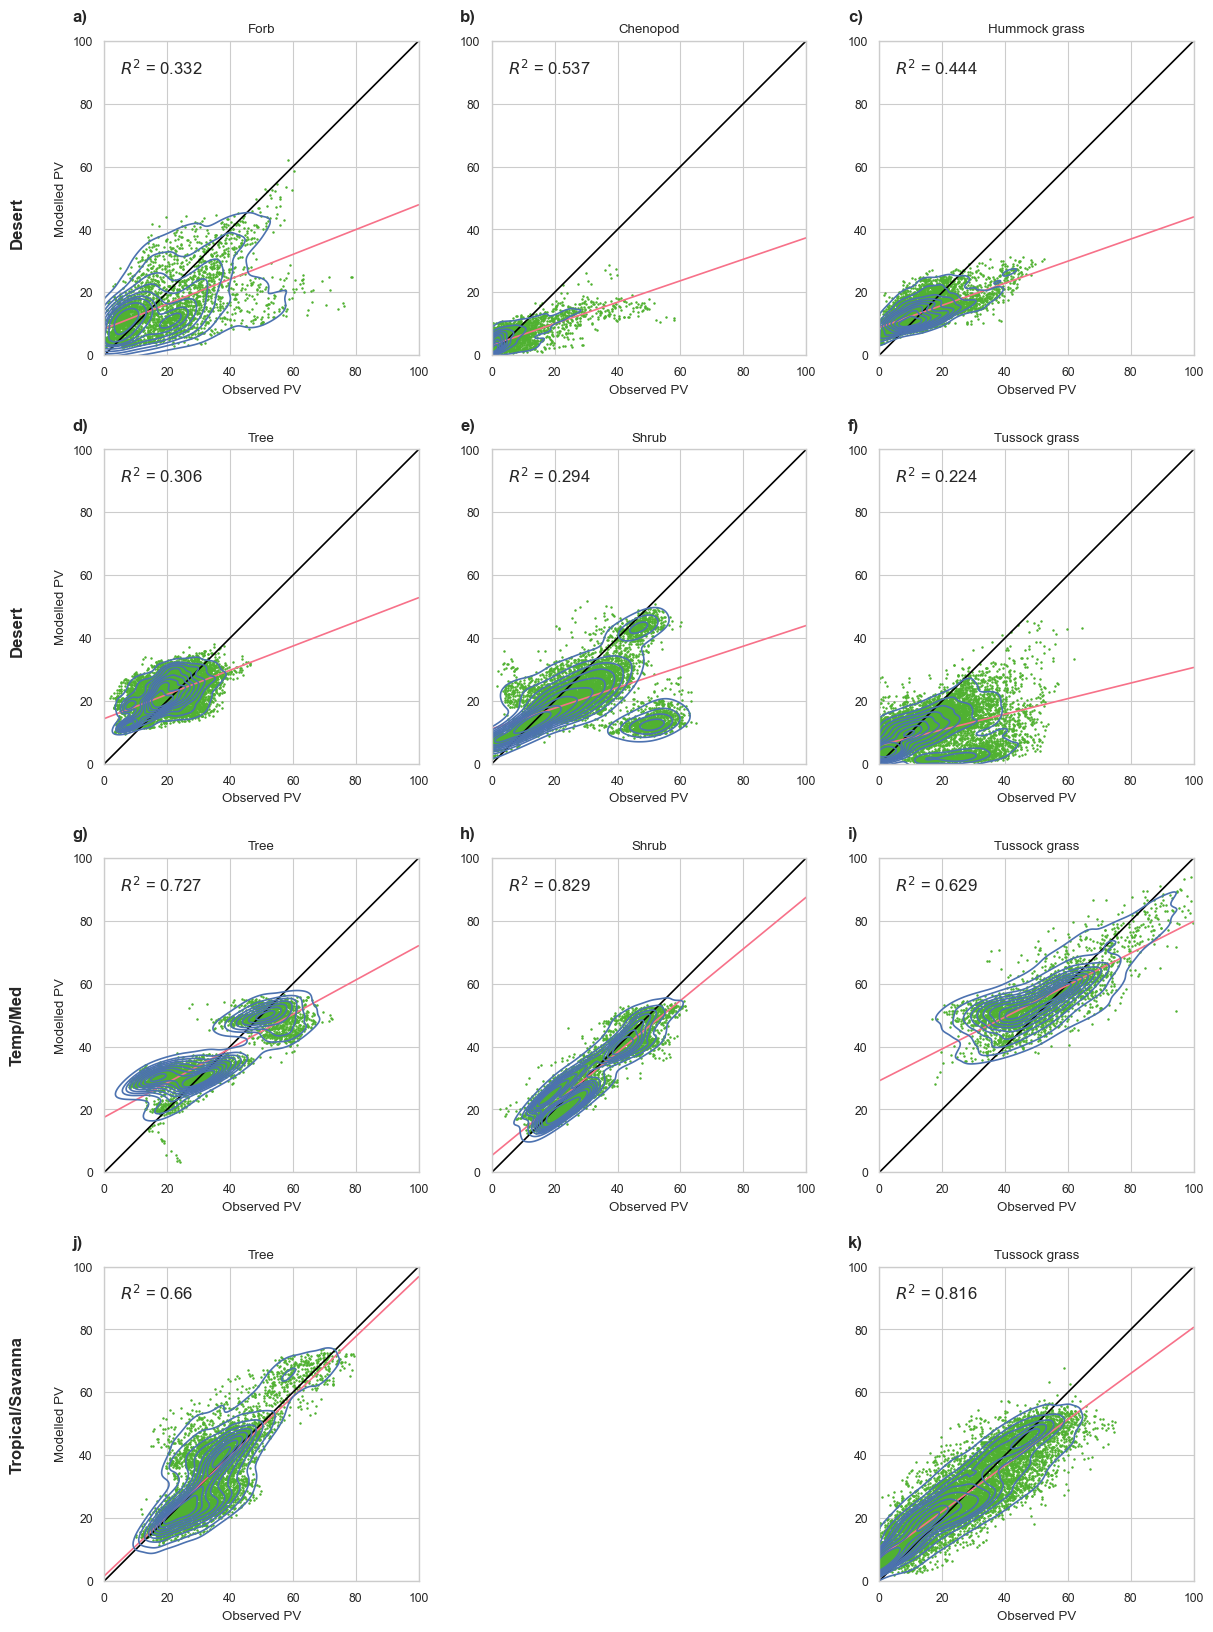

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']
one_to_one = [i for i in range(101)]

for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    test_evaluation_set_group.plot(kind = 'scatter', x = 'pv_filter', y = 'pv_median', ax = ax, s = 0.9, **{'color' : list(sns.color_palette("husl", 3))[1], 'alpha' : 1} )
    ax.plot(one_to_one,one_to_one, color = 'black')
    
    #Add density contours 
    #sns.kdeplot(x= test_evaluation_set_group['pv_filter'],
    #            y= test_evaluation_set_group['pv_median'], ax = ax)
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['pv_filter'], y = test_evaluation_set_group['pv_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue
    
    ax.plot(np.array(one_to_one), np.array(one_to_one)*slope + intercept, **{'color' : list(sns.color_palette("husl", 3))[0]})
    sns.kdeplot(x= test_evaluation_set_group['pv_filter'], y = test_evaluation_set_group['pv_median'], ax = ax)
    
    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    
    adjust_r2 =  1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    adjust_r2 = sigfig.round(adjust_r2, sigfigs=3)
    
    rmse = root_mean_squared_error(test_evaluation_set_group['pv_filter'], test_evaluation_set_group['pv_median'])
    rmse = sigfig.round(rmse, sigfigs=3)
                    
    #bias = np.mean(test_evaluation_set_group['pv_filter']) - np.mean(test_evaluation_set_group['pv_median'])
    #results_metrics_dict[chosen_group] = [slope, intercept, r**2, sigfig.round(adjust_r2, sigfigs=3), p_value, rmse] # square the r to get coefficient of determinaton
   
    # x and y limits 
    ax.set_xlim((0,100))
    ax.set_ylim((0,100))
    ax.set_aspect('equal')
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree'
    ax.title.set_text(f'{veg_name}')
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel('Modelled PV') 
        ax.text(-0.3, 0.35, chosen_group.split(" ")[0], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', rotation=90)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Observed PV')
    
    ax.text(0.05, 0.95, f'$R^2$ = {adjust_r2}', transform=ax.transAxes, 
            fontsize=12, va='top')
    
    
plt.subplots_adjust(wspace=-0.5, hspace=0.3)


In [9]:
fig.savefig(f'{plots_dir}/Total_PV_Evaluation_Plot.png')

# NPV

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


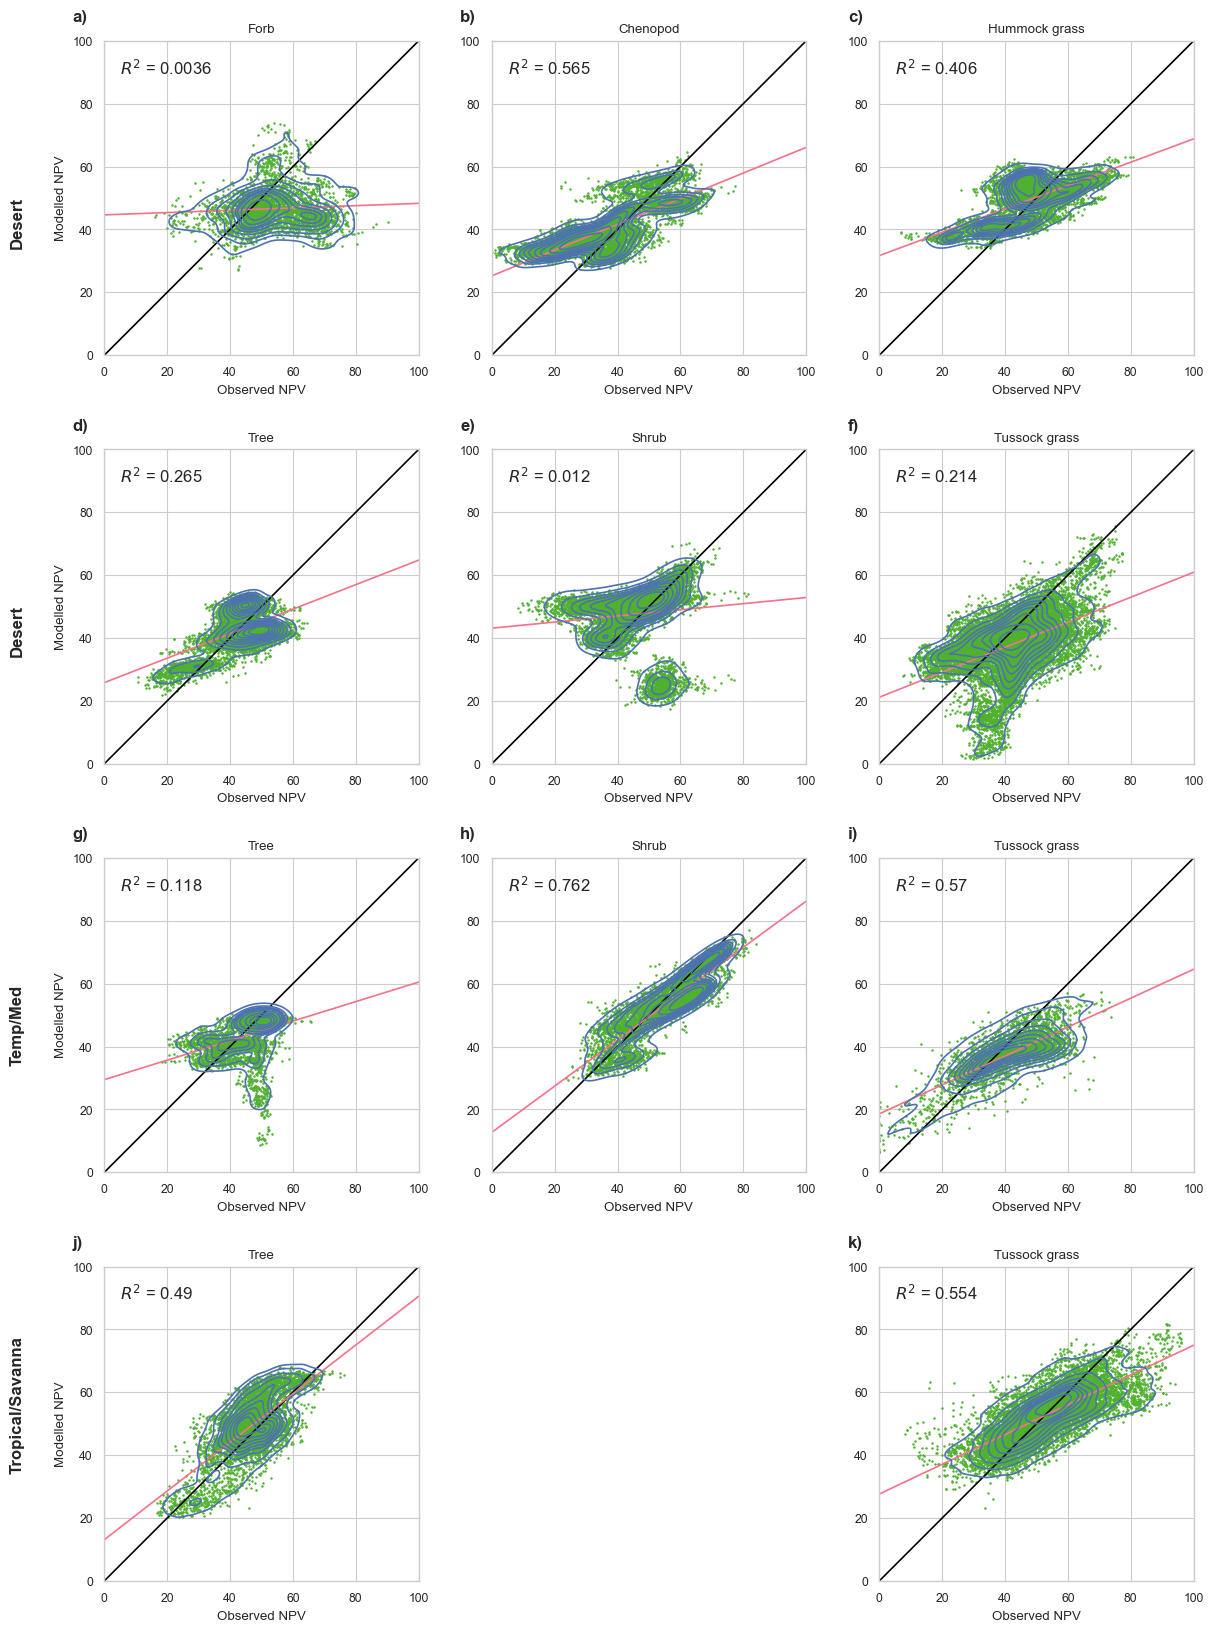

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']
one_to_one = [i for i in range(101)]

for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    test_evaluation_set_group.plot(kind = 'scatter', x = 'npv_filter', y = 'npv_median', ax = ax, s = 0.9, **{'color' : list(sns.color_palette("husl", 3))[1], 'alpha' : 1} )
    ax.plot(one_to_one,one_to_one, color = 'black')
    
    #Add density contours 
    #sns.kdeplot(x= test_evaluation_set_group['npv_filter'],
    #            y= test_evaluation_set_group['pv_median'], ax = ax)
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['npv_filter'], y = test_evaluation_set_group['npv_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue
    
    ax.plot(np.array(one_to_one), np.array(one_to_one)*slope + intercept, **{'color' : list(sns.color_palette("husl", 3))[0]})
    sns.kdeplot(x= test_evaluation_set_group['npv_filter'], y = test_evaluation_set_group['npv_median'], ax = ax)
    
    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    
    adjust_r2 =  1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    adjust_r2 = sigfig.round(adjust_r2, sigfigs=3)
    
    rmse = root_mean_squared_error(test_evaluation_set_group['npv_filter'], test_evaluation_set_group['npv_median'])
    rmse = sigfig.round(rmse, sigfigs=3)
                    
    #bias = np.mean(test_evaluation_set_group['npv_filter']) - np.mean(test_evaluation_set_group['npv_median'])
    #results_metrics_dict[chosen_group] = [slope, intercept, r**2, sigfig.round(adjust_r2, sigfigs=3), p_value, rmse] # square the r to get coefficient of determinaton
   
    # x and y limits 
    ax.set_xlim((0,100))
    ax.set_ylim((0,100))
    ax.set_aspect('equal')
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree'
    ax.title.set_text(f'{veg_name}')
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel('Modelled NPV') 
        ax.text(-0.3, 0.35, chosen_group.split(" ")[0], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', rotation=90)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Observed NPV')
    
    ax.text(0.05, 0.95, f'$R^2$ = {adjust_r2}', transform=ax.transAxes, 
            fontsize=12, va='top')
    
    
plt.subplots_adjust(wspace=-0.5, hspace=0.3)


In [11]:
fig.savefig(f'{plots_dir}/Total_NPV_Evaluation_Plot.png')

## BS

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp/Med Tree.Palm
Temp/Med Shrub
Temp/Med Tussock.grass
Tropical/Savanna Tree.Palm
Tropical/Savanna Tussock.grass


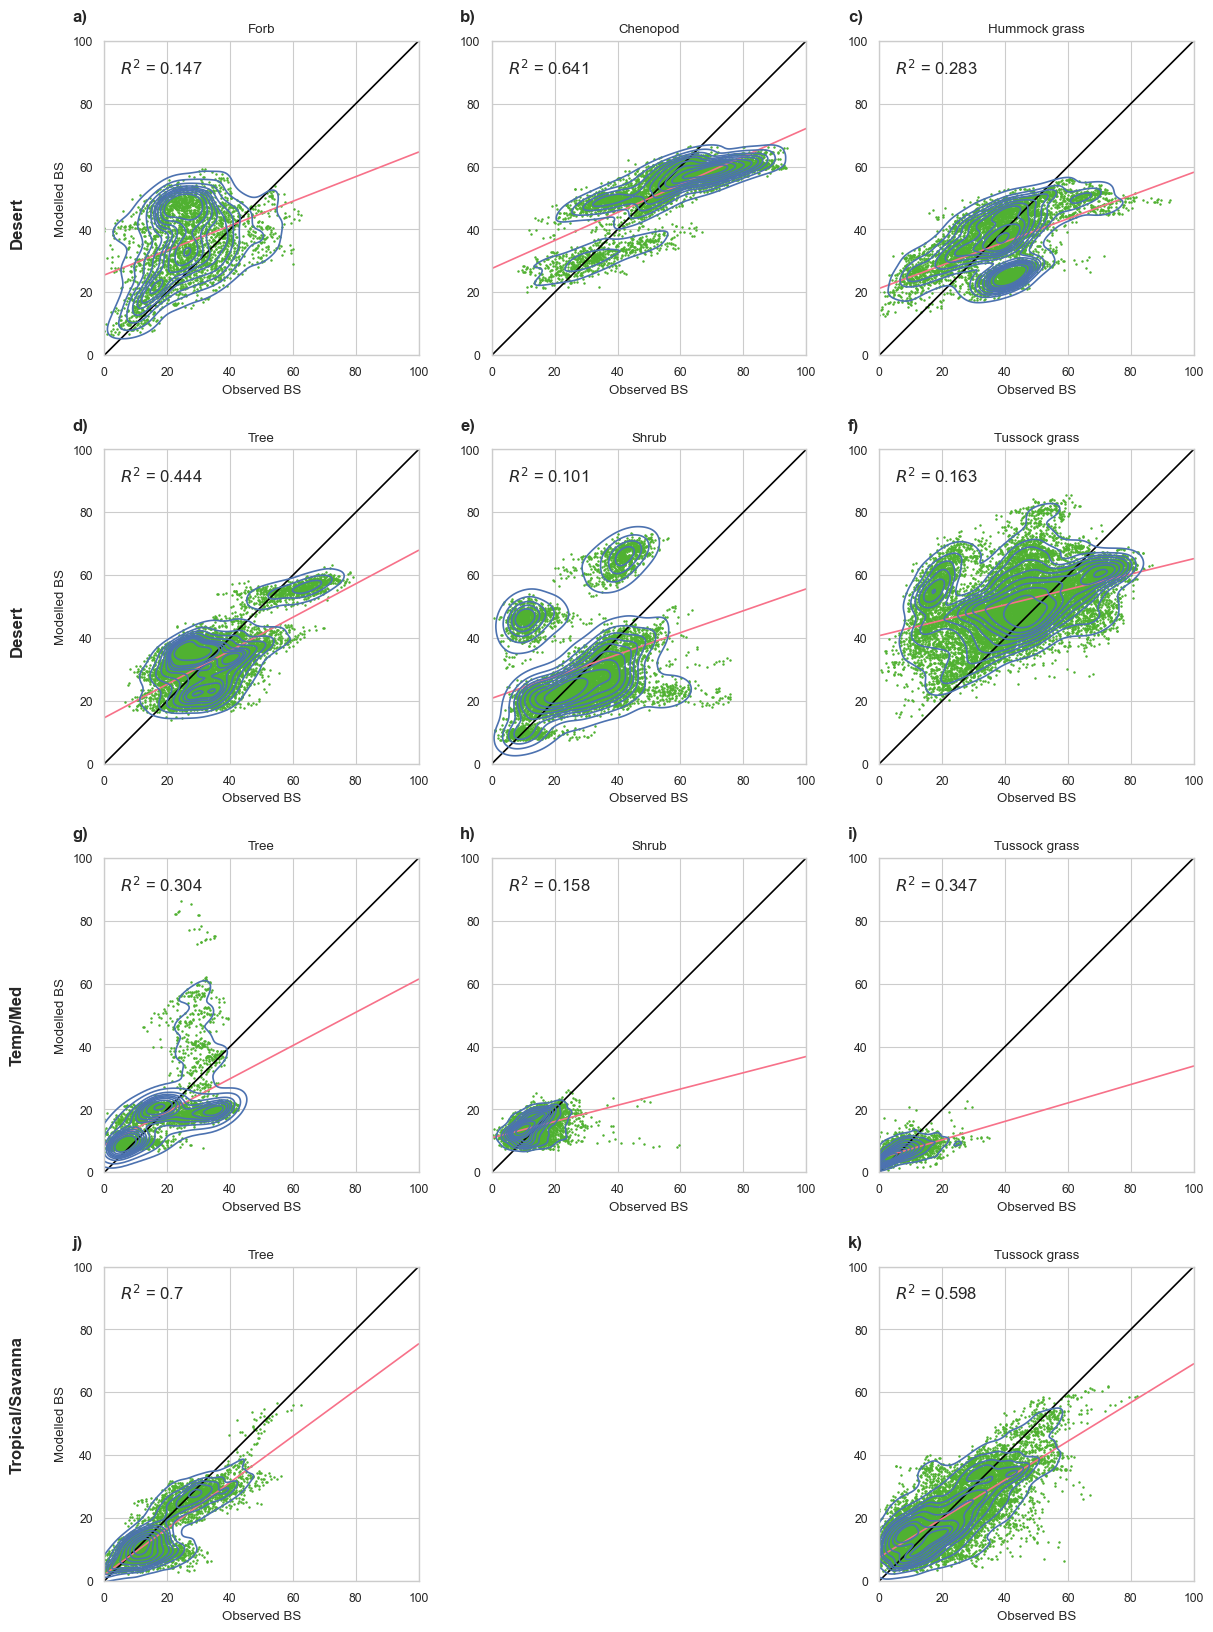

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']
one_to_one = [i for i in range(101)]

for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]
        
    print(chosen_group)
    
    # Plot the points 
    test_evaluation_set_group = test_evaluation_set.loc[test_evaluation_set['group_name'] == chosen_group]
    test_evaluation_set_group.plot(kind = 'scatter', x = 'bs_filter', y = 'bs_median', ax = ax, s = 0.9, **{'color' : list(sns.color_palette("husl", 3))[1], 'alpha' : 1} )
    ax.plot(one_to_one,one_to_one, color = 'black')
    
    #Add density contours 
    #sns.kdeplot(x= test_evaluation_set_group['bs_filter'],
    #            y= test_evaluation_set_group['pv_median'], ax = ax)
    
    # Plot a regression equation 
    
    res = stats.linregress(x = test_evaluation_set_group['bs_filter'], y = test_evaluation_set_group['bs_median'],  alternative = 'two-sided')
    slope, intercept, r, p_value = res.slope, res.intercept, res.rvalue, res.pvalue
    
    ax.plot(np.array(one_to_one), np.array(one_to_one)*slope + intercept, **{'color' : list(sns.color_palette("husl", 3))[0]})
    sns.kdeplot(x= test_evaluation_set_group['bs_filter'], y = test_evaluation_set_group['bs_median'], ax = ax)
    
    # Append the stats to save later:
    # adjust_r2
    n = test_evaluation_set_group.shape[0]
    p = 1 # for the number of parameters; 1 
    
    adjust_r2 =  1 - ( (1-r**2) *  (n - 1) )/(n - p - 1) 
    adjust_r2 = sigfig.round(adjust_r2, sigfigs=3)
    
    rmse = root_mean_squared_error(test_evaluation_set_group['bs_filter'], test_evaluation_set_group['bs_median'])
    rmse = sigfig.round(rmse, sigfigs=3)
                    
    #bias = np.mean(test_evaluation_set_group['bs_filter']) - np.mean(test_evaluation_set_group['bs_median'])
    #results_metrics_dict[chosen_group] = [slope, intercept, r**2, sigfig.round(adjust_r2, sigfigs=3), p_value, rmse] # square the r to get coefficient of determinaton
   
    # x and y limits 
    ax.set_xlim((0,100))
    ax.set_ylim((0,100))
    ax.set_aspect('equal')
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree'
    ax.title.set_text(f'{veg_name}')
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel('Modelled BS') 
        ax.text(-0.3, 0.35, chosen_group.split(" ")[0], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', rotation=90)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Observed BS')
    
    ax.text(0.05, 0.95, f'$R^2$ = {adjust_r2}', transform=ax.transAxes, 
            fontsize=12, va='top')
    
    
plt.subplots_adjust(wspace=-0.5, hspace=0.3)


In [13]:
fig.savefig(f'{plots_dir}/Total_BS_Evaluation_Plot.png')